In [2]:
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.spatial.distance import cosine

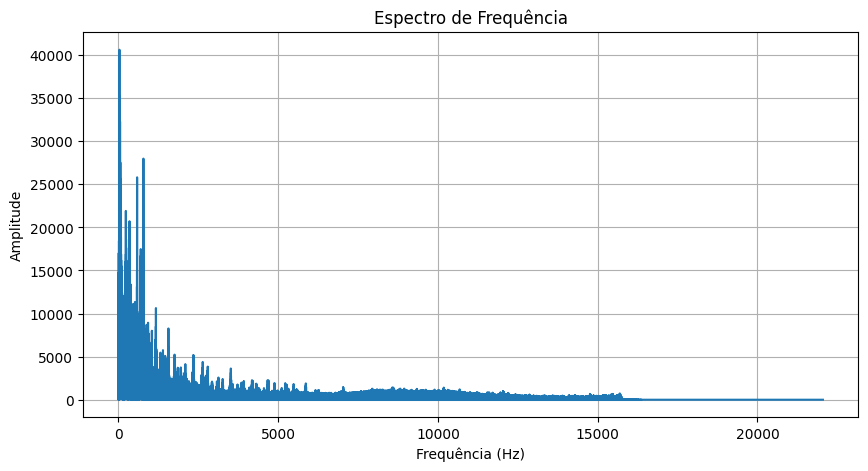

In [4]:

# Carregar arquivo de áudio MP3
def carregar_audio(caminho_audio):
    audio, sr = librosa.load(caminho_audio, sr=None)
    return audio, sr

# Aplicar FFT e calcular espectro de frequência
def calcular_fft(audio, sr):
    fft = np.fft.fft(audio)
    freq = np.fft.fftfreq(len(fft), d=1/sr)
    return fft, freq

# Plotar espectro de frequência
def plotar_espectro(audio, sr):
    fft, freq = calcular_fft(audio, sr)
    plt.figure(figsize=(10, 5))
    plt.plot(freq[:len(freq)//2], np.abs(fft[:len(freq)//2])) # Apenas metade do espectro é relevante
    plt.xlabel("Frequência (Hz)")
    plt.ylabel("Amplitude")
    plt.title("Espectro de Frequência")
    plt.grid()
    plt.show()

# Teste com um arquivo MP3
caminho_audio = r"C:\Users\silva\Downloads\003.mp3"  # Certifique-se de usar 'r' para caminho no Windows
audio, sr = carregar_audio(caminho_audio)
plotar_espectro(audio, sr)

In [6]:
from scipy.spatial.distance import cosine

# Função para carregar e calcular espectro de frequência normalizado
def calcular_espectro_normalizado(caminho_audio):
    audio, sr = librosa.load(caminho_audio, sr=None)
    fft = np.fft.fft(audio)
    espectro = np.abs(fft[:len(fft)//2])  # Pegamos apenas metade do espectro
    espectro_normalizado = espectro / np.linalg.norm(espectro)  # Normalizamos
    return espectro_normalizado

# Calcular similaridade entre dois espectros usando distância de coseno
def calcular_similaridade_coseno(espectro1, espectro2):
    tamanho = min(len(espectro1), len(espectro2))  # Ajuste para comprimentos diferentes
    espectro1 = espectro1[:tamanho]
    espectro2 = espectro2[:tamanho]
    distancia = cosine(espectro1, espectro2)  # Distância de coseno
    return distancia

# Teste com dois arquivos de áudio
caminho_audio1 = r"C:\Users\silva\Downloads\001.mp3"
caminho_audio2 = r"C:\Users\silva\Downloads\002.mp3"  # Substitua pelo segundo arquivo

espectro1 = calcular_espectro_normalizado(caminho_audio1)
espectro2 = calcular_espectro_normalizado(caminho_audio2)

similaridade = calcular_similaridade_coseno(espectro1, espectro2)
print(f"Similaridade entre os espectros (distância de coseno): {similaridade}")

Similaridade entre os espectros (distância de coseno): 0.9408981204032898


In [ ]:
import psycopg2
import numpy as np
import librosa

# 🎯 Conectar ao PostgreSQL
conn = psycopg2.connect(dbname="music_db", user="postgres", password="systemaudiotcc", host="localhost", port="5432")
cursor = conn.cursor()

# 🔎 Funções de processamento de áudio
def extrair_mfcc(caminho_audio):
    audio, sr = librosa.load(caminho_audio, sr=None)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return np.mean(mfccs.T, axis=0)  

def extrair_espectro(caminho_audio):
    audio, sr = librosa.load(caminho_audio, sr=None)
    espectro = np.abs(np.fft.fft(audio)[:5000])  
    return espectro

# 📝 Função para salvar músicas
def salvar_musica(nome, artista, genero, caminho_audio):
    espectro = extrair_espectro(caminho_audio)
    mfcc = extrair_mfcc(caminho_audio)
    
    query = "INSERT INTO music_features (nome, artista, genero, espectro, mfcc) VALUES (%s, %s, %s, %s, %s)"
    cursor.execute(query, (nome, artista, genero, espectro.tolist(), mfcc.tolist()))
    conn.commit()
    print(f"✅ Música '{nome}' adicionada ao banco!")

# 🔍 Função para buscar música semelhante
def buscar_musica(caminho_audio):
    mfcc_novo = extrair_mfcc(caminho_audio)
    cursor.execute("SELECT nome, artista, genero, mfcc FROM music_features")
    resultados = cursor.fetchall()
    
    musica_mais_proxima = None
    menor_distancia = float("inf")
    
    for nome, artista, genero, mfcc_salvo in resultados:
        distancia = np.linalg.norm(mfcc_novo - np.array([float(x) for x in mfcc_salvo]))  
        if distancia < menor_distancia:
            menor_distancia = distancia
            musica_mais_proxima = (nome, artista, genero)

    if musica_mais_proxima:
        print(f"🎵 Música mais próxima identificada: {musica_mais_proxima[0]}")
        print(f"🎤 Artista: {musica_mais_proxima[1]}")
        print(f"🎶 Gênero: {musica_mais_proxima[2]}")
        print(f"🔎 Distância de similaridade: {menor_distancia}")
    else:
        print("Nenhuma correspondência encontrada.")

# 🚀 Testando o código corretamente
#salvar_musica("Patricinha", "Forró Saborear", "Forró", r"C:\Users\silva\Downloads\003.mp3")
#salvar_musica("Defeito Meu", "Silvanno Salles", "Arrocha", r"C:\Users\silva\Downloads\004.mp3")

buscar_musica(r"C:\Users\silva\Downloads\003.mp3")

🎵 Música identificada: Patricinha
🎤 Artista: Forró Saborear
🎶 Gênero: Forró
🔎 Distância de similaridade: 0.0
